# Visualization with ``EOCube``

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt

# from eobox.raster import MultiRasterIO
from eobox import sampledata
from eobox.raster import cube
from eobox.raster import gdalutils

from eobox.raster.utils import cleanup_df_values_for_given_dtype
from eobox.raster.utils import dtype_checker_df

print(cube.__file__)
print(sampledata.__file__)

/home/ben/Devel/Packages/eo-box/raster/eobox/raster/cube.py
/home/ben/Devel/Packages/eo-box/sampledata/eobox/sampledata/__init__.py


## Sample dataset

In [2]:
def get_sampledata(year):
    dataset = sampledata.get_dataset("lsts")
    layers_paths = [Path(p) for p in dataset["raster_files"]]
    layers_df = pd.Series([p.stem for p in layers_paths]).str.split("_", expand=True) \
    .rename({0: "sceneid", 1:"band"}, axis=1)

    layers_df["date"] = pd.to_datetime(layers_df.sceneid.str[9:16], format="%Y%j")
    layers_df["uname"] = layers_df.sceneid.str[:3] + "_" + layers_df.date.dt.strftime("%Y-%m-%d") + "_" + layers_df.band.str[::] 
    layers_df["path"] = layers_paths

    layers_df = layers_df.sort_values(["date", "band"])
    layers_df = layers_df.reset_index(drop=True)

    layers_df_year = layers_df[(layers_df.date >= str(year)) & (layers_df.date < str(year+1))]
    layers_df_year = layers_df_year.reset_index(drop=True)
    return layers_df_year

The sample data we are loading here contains 23 scenes each of which consists of three bands (*b3*, *b4*, *b5*) and a QA (quality assessment) band (here *fmask*).

*fmask* has the following categories:

      0 - clear land
      1 - clear water
      2 - cloud
      3 - snow
      4 - shadow
    255 - NoData

In [3]:
df_layers = get_sampledata(2008)
display(df_layers.head(4))
print(df_layers.band.value_counts())
print(df_layers.date.dt.strftime("%Y-%m-%d").unique())

,sceneid,band,date,uname,path
0,LT50350322008110PAC01,b3,2008-04-19,LT5_2008-04-19_b3,/home/ben/Devel/Packages/eo-box/sampledata/eob...
1,LT50350322008110PAC01,b4,2008-04-19,LT5_2008-04-19_b4,/home/ben/Devel/Packages/eo-box/sampledata/eob...
2,LT50350322008110PAC01,b5,2008-04-19,LT5_2008-04-19_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...
3,LT50350322008110PAC01,fmask,2008-04-19,LT5_2008-04-19_fmask,/home/ben/Devel/Packages/eo-box/sampledata/eob...


fmask    23
b4       23
b5       23
b3       23
Name: band, dtype: int64
['2008-04-19' '2008-04-27' '2008-05-05' '2008-05-21' '2008-05-29'
 '2008-06-06' '2008-06-14' '2008-06-22' '2008-06-30' '2008-07-08'
 '2008-07-16' '2008-07-24' '2008-08-01' '2008-08-09' '2008-08-17'
 '2008-08-25' '2008-09-02' '2008-09-18' '2008-09-26' '2008-10-12'
 '2008-10-28' '2008-11-21' '2008-12-07']


**Initialize an ``EOCubeSceneCollection``**

In [4]:
df_layers=df_layers
chunksize=2**5
variables=["b3", "b4", "b5"]
qa="fmask"
qa_valid=[0, 1]

**Get a chunk and read the data**

In [5]:
scoll = cube.EOCubeSceneCollection(df_layers=df_layers, 
                                   chunksize=chunksize, 
                                   variables=variables, 
                                   qa=qa, 
                                   qa_valid=qa_valid 
                                  )
display(scoll.df_layers.head())

scoll_chunk = scoll.get_chunk(1)
scoll_chunk.read_data()
scoll_chunk.data.shape

,sceneid,band,date,uname,path
0,LT50350322008110PAC01,b3,2008-04-19,LT5_2008-04-19_b3,/home/ben/Devel/Packages/eo-box/sampledata/eob...
1,LT50350322008110PAC01,b4,2008-04-19,LT5_2008-04-19_b4,/home/ben/Devel/Packages/eo-box/sampledata/eob...
2,LT50350322008110PAC01,b5,2008-04-19,LT5_2008-04-19_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...
3,LT50350322008110PAC01,fmask,2008-04-19,LT5_2008-04-19_fmask,/home/ben/Devel/Packages/eo-box/sampledata/eob...
4,LE70350322008118EDC00,b3,2008-04-27,LE7_2008-04-27_b3,/home/ben/Devel/Packages/eo-box/sampledata/eob...


(32, 29, 92)

## Plotting raster

### Single layer

#### Continuous

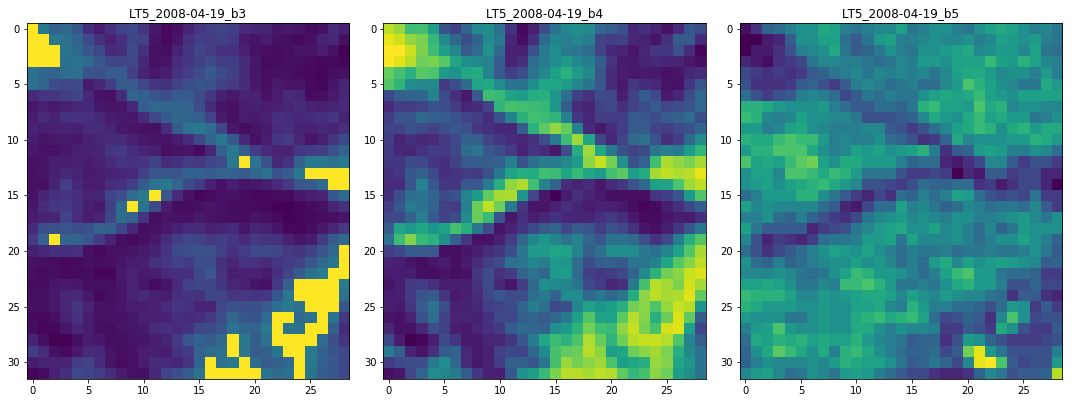

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

aximg = scoll_chunk.plot_raster(0, spatial_bounds=False, ax=axes[0])
axes[0].set_title(scoll_chunk.df_layers.uname[0])

aximg = scoll_chunk.plot_raster(1, spatial_bounds=False, ax=axes[1])
axes[1].set_title(scoll_chunk.df_layers.uname[1])

aximg = scoll_chunk.plot_raster(2, spatial_bounds=False, ax=axes[2])
axes[2].set_title(scoll_chunk.df_layers.uname[2])

plt.tight_layout()

#### Categorical

**ToDo**

### RGBs

There is a helper for getting the indices of commonly required for RGB plots:

In [7]:
# three bands, one date
ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-06-30")
print(ilocs)
display(scoll_chunk.df_layers.iloc[ilocs])
# one band, three dates
ilocs = scoll_chunk.get_df_ilocs(band="b5", 
                                 date=['2008-04-19', '2008-07-08', '2008-09-26'])
print(ilocs)
display(scoll_chunk.df_layers.iloc[ilocs])


[34, 33, 32]


,sceneid,band,date,uname,path
34,LE70350322008182EDC00,b5,2008-06-30,LE7_2008-06-30_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...
33,LE70350322008182EDC00,b4,2008-06-30,LE7_2008-06-30_b4,/home/ben/Devel/Packages/eo-box/sampledata/eob...
32,LE70350322008182EDC00,b3,2008-06-30,LE7_2008-06-30_b3,/home/ben/Devel/Packages/eo-box/sampledata/eob...


[2, 38, 74]


,sceneid,band,date,uname,path
2,LT50350322008110PAC01,b5,2008-04-19,LT5_2008-04-19_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...
38,LT50350322008190PAC01,b5,2008-07-08,LT5_2008-07-08_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...
74,LT50350322008270PAC01,b5,2008-09-26,LT5_2008-09-26_b5,/home/ben/Devel/Packages/eo-box/sampledata/eob...


Plot false color RGB (SWIR-1, NIR, RED) of tree days. 
Each with its own robust color stretch.

[2, 1, 0]
[38, 37, 36]
[74, 73, 72]


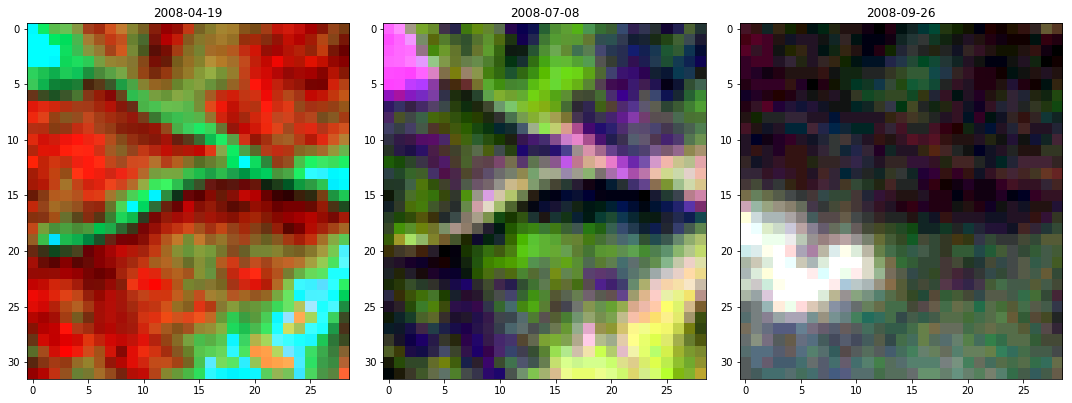

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-04-19")
print(ilocs)
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            robust=True,
                            ax=axes[0])
axes[0].set_title("2008-04-19")


ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-07-08")
print(ilocs)
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            robust=True,
                            ax=axes[1])
axes[1].set_title("2008-07-08")

ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-09-26")
print(ilocs)
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            robust=True,
                            ax=axes[2])
axes[2].set_title("2008-09-26")

plt.tight_layout()

Plot false color RGB (SWIR-1, NIR, RED) of tree days. 
All with the same color stretch derived from the first image.

In [9]:
master_ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                        date="2008-04-19")
master_array = scoll_chunk.data[:, :, master_ilocs]

vmin, vmax = scoll_chunk.robust_data_range(master_array, robust=True)
print(vmin)
print(vmax)

[339.0, 2016.0, 1092.0]
[734.0, 6972.180000000001, 16000.0]


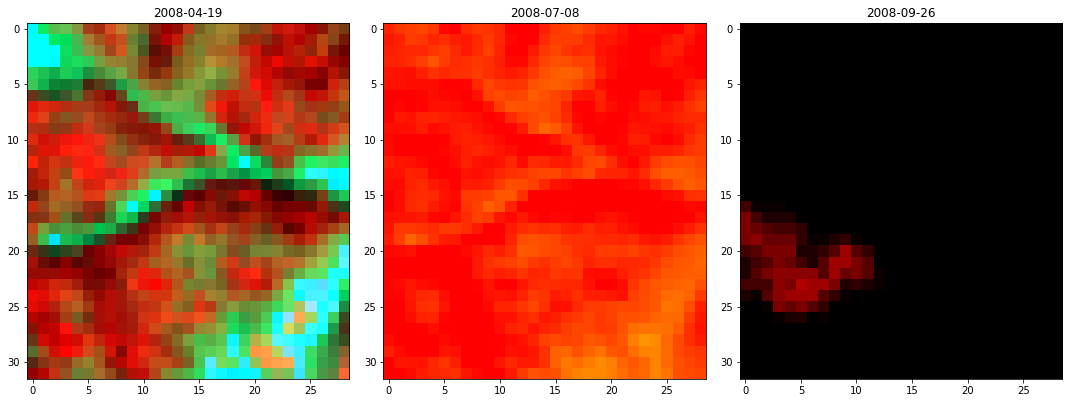

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-04-19")
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            vmin=vmin, vmax=vmax,
                            ax=axes[0])
axes[0].set_title("2008-04-19")


ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-07-08")
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            vmin=vmin, vmax=vmax,
                            ax=axes[1])
axes[1].set_title("2008-07-08")

ilocs = scoll_chunk.get_df_ilocs(band=["b5", "b4", "b3"], 
                                 date="2008-09-26")
scoll_chunk.plot_raster_rgb(ilocs, 
                            spatial_bounds=False, 
                            vmin=vmin, vmax=vmax,
                            ax=axes[2])
axes[2].set_title("2008-09-26")

plt.tight_layout()

IS HERE SOMETHING WRONG WITH THE CODE OR THE DATA?